In [37]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [38]:
nu = 2
N_Sam = 20
n_generator = 2

random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[ 0.22777036 -0.09779448  0.2208292   0.16947159  0.7073105  -0.41726673
   0.614101    0.99931519  0.2365562   0.02722342 -0.37598221  0.17218187
  -0.18335025 -0.99917361 -0.22563456 -0.16139334 -0.79770112  0.7571665
   0.99109336  0.29077025]
 [ 0.4957734   0.97757222  0.29946028 -0.3188749  -0.37263743 -0.08338416
   0.38703347 -0.93309395  0.56110088  0.38308269  0.15072969 -0.42372697
  -0.9431057  -0.66879615 -0.50666648  0.86201787  0.80428181  0.84393574
   0.99192607  0.04003325]]


In [39]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 14]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
print(random_vals.shape)
N_Sam = random_vals.shape[1]


(2, 494)


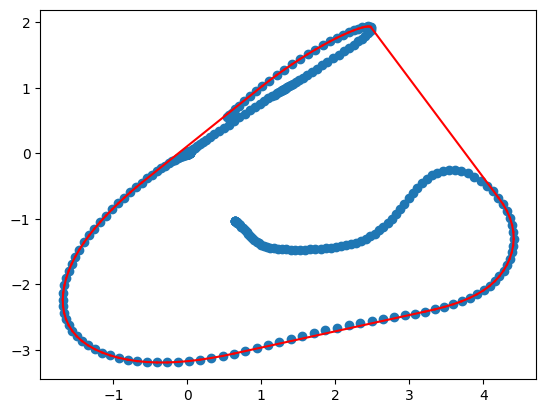

Convex Hull Points (2xN):
 [[ 4.38841  4.35951  4.31862  4.26609  4.20289  2.48128  2.46711  2.44288
   2.40878  2.36508  2.31213  2.25032  2.18012  2.10213  2.01713  1.92603
   1.82982  1.72948  1.62616  1.52107  1.4154   1.31039  1.20733  1.10748
   1.01217 -0.61451 -0.69021 -0.76888 -0.84979 -0.93205 -1.01469 -1.09665
  -1.17681 -1.25404 -1.32726 -1.39551 -1.4579  -1.51373 -1.56241 -1.60344
  -1.63638 -1.66086 -1.67647 -1.68268 -1.67888 -1.6645  -1.63908 -1.60224
  -1.55378 -1.49378 -1.42257 -1.34075 -1.24917 -1.14882 -1.04072 -0.92567
  -0.80432 -0.67729 -0.54522 -0.40871 -0.2683  -0.12437  0.02255  0.17189
   0.3231   0.47556  0.62866  3.21341  3.34484  3.47099  3.59138  3.70562
   3.813    3.91247  4.00297  4.08404  4.15555  4.2181   4.27244  4.31864
   4.35624  4.38442  4.4025   4.40969  4.40513]
 [-1.09312 -0.98649 -0.88043 -0.77605 -0.6751   1.92518  1.93414  1.93659
   1.9324   1.9214   1.90342  1.87835  1.84622  1.80705  1.76089  1.70802
   1.64883  1.58379  1.51346  1.4385 

In [40]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Example set of points (shape: 2x30)
points = random_vals

# Reshape to (30, 2) so ConvexHull can process it
points = points.T  # Transpose to make it (30, 2)

# Compute the convex hull
hull = ConvexHull(points)

# Plot the points and the convex hull
plt.scatter(points[:, 0], points[:, 1])
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
plt.show()

# Convex hull vertices (in (N, 2) shape)
convex_points = points[hull.vertices]

# Reshape the convex hull points to 2xN
convex_points = convex_points.T  # Transpose back to 2xN shape

print("Convex Hull Points (2xN):\n", convex_points)
N_Convex = convex_points.shape[1]
print(hull.area)

In [41]:
def opti_zono():
    opti = ca.Opti()

    c = opti.variable(nu,1)
    g = opti.variable(nu,n_generator)
    lam = opti.variable(n_generator,N_Convex)
    lam_bound = opti.variable(n_generator,1)

    samples = opti.parameter(nu,N_Convex)

    opti.minimize(ca.sum1(lam_bound))

    for i in range(N_Convex):
        opti.subject_to(samples[:,i] ==  c + g@lam[:,i])

    for i in range(n_generator):
        for j in range(N_Convex):
            opti.subject_to(lam[i, j] >= -lam_bound[i])
            opti.subject_to(lam[i, j] <= lam_bound[i]) 


    opts = {"ipopt.print_level": 4, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [c, g, lam]) 

In [42]:
pass
# f = opti_zono()
# c_hat, g_hat,lam_hat = f(convex_points)
# print(c_hat, g_hat,lam_hat)

In [43]:
def opti_circle(P):
    center = ca.SX.sym('center', 2)  # (x, y)
    radius = ca.SX.sym('radius') 
    
    constraints = []
    N = P.shape[1]
    for i in range(N):
        p1 = P[:, i]
        p2 = P[:, (i + 1) % N]

        edge = p2 - p1
        normal = np.array([-edge[1], edge[0]]) 
        normal = normal / np.linalg.norm(normal)

        distance = ca.dot(normal, center - p1)

        constraints.append(distance - radius)
    g = ca.vertcat(*constraints)

    objective = -radius 

    nlp = {'x': ca.vertcat(center, radius), 'f': objective, 'g': g}
    solver = ca.nlpsol('solver', 'ipopt', nlp)
    x0 = [np.mean(P[0, :]), np.mean(P[1, :]), 0.1]
    lbx = [-ca.inf, -ca.inf, 0]  # x, y, r >= 0
    ubx = [ca.inf, ca.inf, ca.inf]

    lbg = [0] * N 
    ubg = [ca.inf] * N 

    sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

    optimal_center = np.array(sol['x'][0:2].full()).flatten()
    optimal_radius = float(sol['x'][2])

    return optimal_center,optimal_radius

In [44]:
from scipy.optimize import minimize
def minimize_convex_hull_area(convex_points, center_initial=np.array([0, 0])):
    # Objective function to minimize: area of the convex hull
    def objective(center):
        # Apply the transformation to get the rotated points
        rotated_x = -convex_points[0, :] + 2 * center[0]
        rotated_y = -convex_points[1, :] + 2 * center[1]
        rotated_convex_points = np.array([rotated_x, rotated_y])
        
        # Stack the original convex points with the rotated points
        stacked_points = np.hstack((convex_points, rotated_convex_points))
        
        # Compute the convex hull of the stacked points
        hull = ConvexHull(stacked_points.T)  # Transpose to (N, 2)
        
        # Return the area of the convex hull
        return hull.area

    # Minimize the area of the convex hull by optimizing the center
    result = minimize(objective, center_initial, method='BFGS')

    # Optimized center
    optimized_center = result.x
    
    # Calculate the minimized convex hull area
    rotated_x = -convex_points[0, :] + 2 * optimized_center[0]
    rotated_y = -convex_points[1, :] + 2 * optimized_center[1]
    rotated_convex_points = np.array([rotated_x, rotated_y])

    stacked_points = np.hstack((convex_points, rotated_convex_points))
    hull = ConvexHull(stacked_points.T)  # Transpose to (N, 2)
    minimized_area = hull.area
    
    return optimized_center, minimized_area

In [45]:
center,b = minimize_convex_hull_area(convex_points)

(2, 85)


<Figure size 640x480 with 0 Axes>

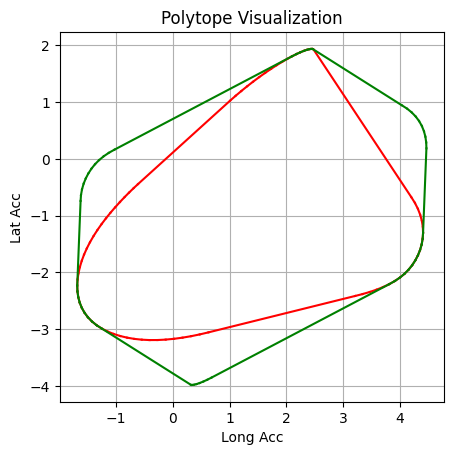

In [46]:

rotated_x = -convex_points[0,:]+2*center[0]
rotated_y = -convex_points[1,:]+2*center[1]
rotated_convex_points = np.array([rotated_x,rotated_y])
stacked_points = np.hstack((convex_points, rotated_convex_points))
plt.figure()
fig, ax = plt.subplots()
#sample points
#plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
#plt.scatter(rotated_convex_points[0,:],rotated_convex_points[1,:],marker='x',color = 'blue')


#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

points = stacked_points.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'g-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

In [47]:
center, radius = opti_circle(convex_points)
print(convex_points.shape)
rotated_x = -convex_points[0,:]+2*center[0]
rotated_y = -convex_points[1,:]+2*center[1]
rotated_convex_points = np.array([rotated_x,rotated_y])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      255
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       85
        inequality constraints with only lower bounds:       85
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 0.00e+00 9.79e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [48]:
stacked_points = np.hstack((convex_points, rotated_convex_points))

<Figure size 640x480 with 0 Axes>

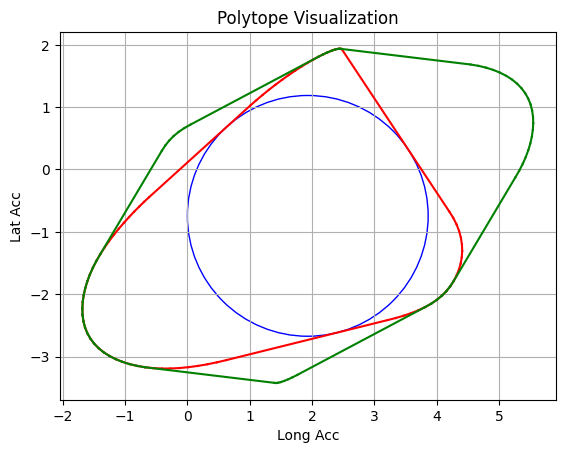

In [49]:
plt.figure()
fig, ax = plt.subplots()
#sample points
#plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
#plt.scatter(rotated_convex_points[0,:],rotated_convex_points[1,:],marker='x',color = 'blue')

circle = plt.Circle(center, radius, color='blue', fill=False)

# Add the circle to the plot
ax.add_artist(circle)

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

points = stacked_points.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'g-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()